<a href="https://colab.research.google.com/github/AbbasRahimi/netgan/blob/testing/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b testing https://github.com/AbbasRahimi/netgan.git

Cloning into 'netgan'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 295 (delta 90), reused 73 (delta 38), pack-reused 149
Receiving objects: 100% (295/295), 50.76 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [2]:
%cd netgan
#!pip install python-igraph


/content/netgan


In [3]:

!pip install -r requirements.txt


     |████████████████████████████████| 3.2MB 12.5MB/s 
  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp37-none-any.whl size=24789 sha256=01a69e6ded905888ee9d65060859a2d452855a04d90a885167d94a6fda4b733f
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [1]:
#import tensorflow as tf
from netgan.netgan import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from netgan import utils
import scipy.sparse as sp
from netgan import graph_utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


#### Load the data

In [2]:
_A_obs,out1, out2, out3, out4, out5, out6 = utils.load_csr_from_model("car_wash.ecore","CarWash01.xmi")
# _A_obs,out1, out2, out3, out4, out5, out6 = utils.load_csr_from_model("basicfamily.ecore","Family100.xmi")
lcc = utils.largest_connected_components(_A_obs)
print("lcc: ",len(lcc))
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Start loading csr from model. (utils.py-line 48)
Matrix for NetGAN:  208 
 [[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Selecting 1 largest connected components
lcc:  37


(37, 37)
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


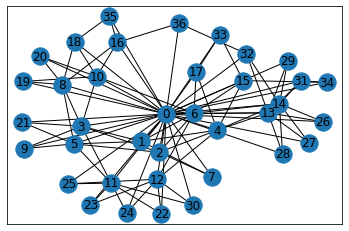

In [3]:
graph_utils.plot_graph_from_sparse_matrix(_A_obs)
# print('A:', type(_A_obs), '\n', _A_obs)
# print('X:', type(_X_obs), '\n', _X_obs)
# print('z:', type(_z_obs), '\n', _z_obs)

In [4]:
val_share = 0.1
test_share = 0.05
#seed = 481516234

#### Separate the edges into train, test, validation

In [5]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, undirected=True, connected=True, asserts=True)

test_ones:  16 neg_mul:  1
random_sample 21 _ 21
test_zeros02:  1
random_sample[:, 0]:  [27 11  6 36 35 15 21 35 31 30 36 29 34 21 23 30 20 27 11 24 34]
random_sample[:, 1]:  [ 0  4  4 14 23 13  5  0  5  0 34  3 13  9  2  3 17 14  2  2 13]
test_zeros0:  16
test_zeros1:  16
n_test: 16 test_zeros.shape[0]: 16


In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [7]:
print(train_graph)

  (0, 1)	1.0
  (0, 2)	1.0
  (0, 4)	1.0
  (0, 7)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 18)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  (0, 27)	1.0
  (0, 28)	1.0
  (0, 29)	1.0
  (0, 30)	1.0
  (0, 31)	1.0
  (0, 32)	1.0
  (0, 33)	1.0
  :	:
  (28, 14)	1.0
  (29, 0)	1.0
  (29, 14)	1.0
  (30, 0)	1.0
  (30, 11)	1.0
  (30, 12)	1.0
  (31, 0)	1.0
  (31, 13)	1.0
  (31, 14)	1.0
  (31, 34)	1.0
  (32, 0)	1.0
  (32, 14)	1.0
  (32, 36)	1.0
  (33, 0)	1.0
  (33, 15)	1.0
  (33, 17)	1.0
  (34, 0)	1.0
  (34, 15)	1.0
  (34, 31)	1.0
  (35, 0)	1.0
  (35, 16)	1.0
  (35, 18)	1.0
  (36, 0)	1.0
  (36, 16)	1.0
  (36, 32)	1.0


#### Parameters

In [8]:
rw_len = 6
batch_size = 32

In [9]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [10]:
walker.walk().__next__()

array([[25, 12, 22,  0, 35, 16],
       [21,  0,  4,  0, 27, 13],
       [22,  0, 31,  0, 35,  0],
       [24, 12, 23,  0, 10, 18],
       [20,  0, 21,  3, 10, 18],
       [21,  0,  1,  7,  2,  0],
       [28, 13, 28, 14,  6,  1],
       [25,  0, 30, 11, 25, 12],
       [22, 12, 22, 12, 24, 11],
       [27, 14, 26,  0, 22,  0],
       [19, 10, 20, 10,  0, 16],
       [23,  0, 20,  8, 18,  0],
       [15,  6, 14, 27, 13, 27],
       [25,  0, 14, 31, 13,  4],
       [23, 11,  0, 32, 36, 16],
       [ 8, 19, 10,  3, 21,  5],
       [29, 14, 31,  0, 27, 13],
       [ 8,  3,  9,  5,  8, 18],
       [ 3,  9,  3,  9,  3,  9],
       [ 8,  5, 21,  3, 21,  0],
       [ 8, 18, 10,  0,  2,  6],
       [21,  5, 11,  5, 21,  0],
       [33, 15,  6,  2,  0, 25],
       [ 3,  2,  7,  2,  0, 18],
       [36, 32, 36, 16,  0, 26],
       [ 0, 33, 17,  6,  2,  6],
       [29, 14, 27, 13, 31, 13],
       [15, 34,  0,  7,  1,  5],
       [28, 14,  4, 14,  0,  7],
       [29,  0, 25, 11,  0, 28],
       [ 1

#### Create our NetGAN model

In [11]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=32, W_down_generator_size=32,batch_size=32,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[10], discriminator_layers=[8], temp_start=5, learning_rate=0.03)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
this is output in generator_recurrent :  Tensor("Generator/add_4:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_9:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_14:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_19:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_24:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_29:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_4:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_9:0", shape=(32, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_14:0", sh

c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

#### Define the stopping criterion

In [12]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [13]:
eval_every = 100
plot_every = 100

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_26.ckpt ****
**** Initializing... ****
**** Done.           ****
this is output in generator_recurrent :  Tensor("Generator_2/add_4:0", shape=(30000, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_9:0", shape=(30000, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_14:0", shape=(30000, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_19:0", shape=(30000, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_24:0", shape=(30000, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_29:0", shape=(30000, 37), dtype=float32)
**** Starting training. ****
mat is equal:  (37, 37)
**** Iter 100    Val ROC 0.810, AP: 0.831, EO 0.327 ****
mat is equal:  (37, 37)
**** Iter 200    Val ROC 0.660, AP: 0.611, EO 0.385 ****
mat is equ

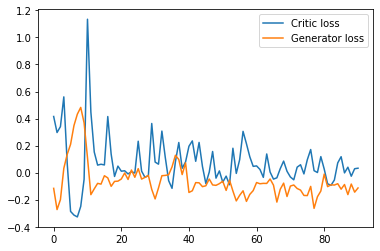

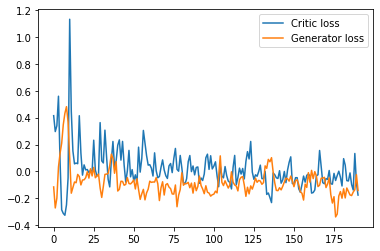

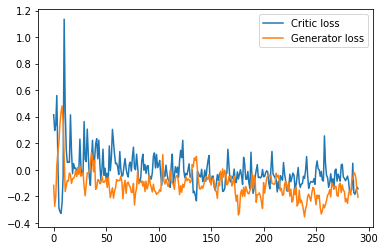

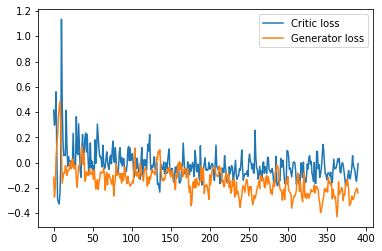

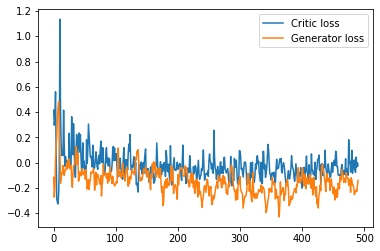

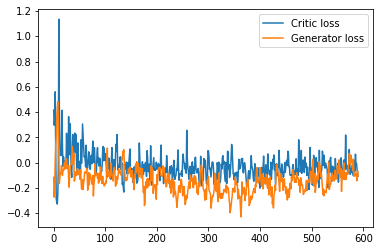

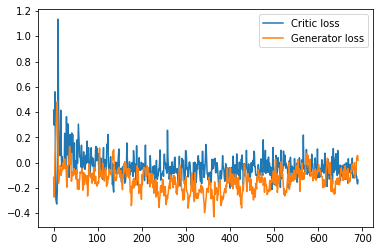

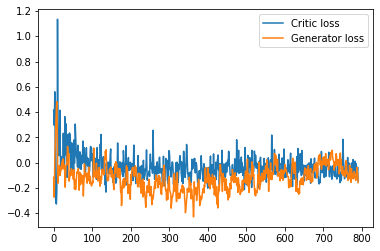

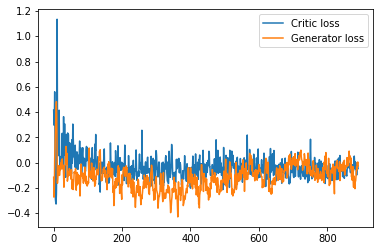

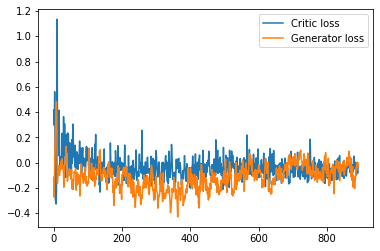

In [14]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=5, max_iters=1000)

In [15]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

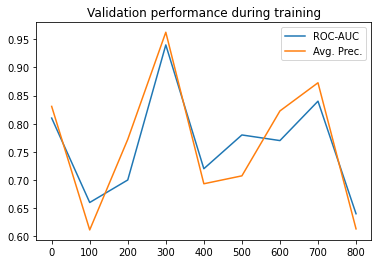

In [16]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

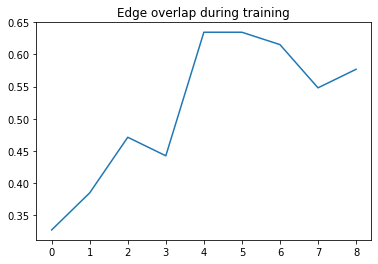

In [17]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [18]:
sample_many = netgan.generate_discrete(1200, reuse=True)

this is output in generator_recurrent :  Tensor("Generator_3/add_4:0", shape=(1200, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_9:0", shape=(1200, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_14:0", shape=(1200, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_19:0", shape=(1200, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_24:0", shape=(1200, 37), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_29:0", shape=(1200, 37), dtype=float32)


c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

In [19]:
samples = []

In [20]:
for _ in range(1000):
    if (_+1) % 150 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

149
299
449
599
749
899


#### Assemble score matrix from the random walks

In [21]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()
# graph_utils.plot_graph_from_sparse_matrix(scores_matrix)

mat is equal:  (37, 37)


(37, 37)
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


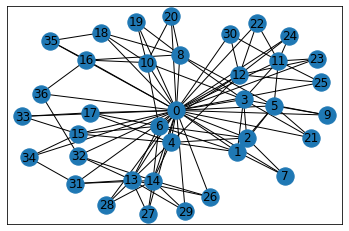

In [22]:
graph_utils.plot_graph_from_sparse_matrix(_A_obs)

LCC: 37
generated_graph:  (37, 37)
scores_matrix:  (37, 37)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


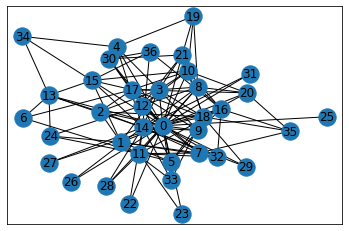

In [23]:
n_edges=250
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)

In [24]:
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,generated_graph)
# graph_utils.graph_similarity(_A_obs,generated_graph,0, 0,180)

adj_matrix: [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
adj_matrix: [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
adj_matrix: [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
adj_matrix: [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
adj_matrix: [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
adj_matrix

#### Evaluate generalization via link prediction

In [30]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))
print("test_ones.T: ",test_ones.T)
print("len(test_ones): ",len(test_ones))
print("tuple(test_ones.T): ",tuple(test_ones.T))
print("tuple(test_zeros.T): ",tuple(test_zeros.T))
print("test_ones: ",scores_matrix[tuple(test_ones.T)])
print("test_ones: ",scores_matrix[tuple(test_zeros.T)])
print("test_ones.A1: ",scores_matrix[tuple(test_ones.T)].A1)
print("test_zeros.A1: ",scores_matrix[tuple(test_zeros.T)].A1)
print("test_labels : ",test_labels)
print("test_scores : ",test_scores)

test_ones.T:  [[50 40 34 39 25 23 11 43 34 47 29  2  0 11 13 13 10  0 13  7  2  0]
 [ 2  0 11 13 13 10  0 13  7  2  0 50 40 34 39 25 23 11 43 34 47 29]]
len(test_ones):  22
tuple(test_ones.T):  (array([50, 40, 34, 39, 25, 23, 11, 43, 34, 47, 29,  2,  0, 11, 13, 13, 10,
        0, 13,  7,  2,  0], dtype=int32), array([ 2,  0, 11, 13, 13, 10,  0, 13,  7,  2,  0, 50, 40, 34, 39, 25, 23,
       11, 43, 34, 47, 29], dtype=int32))
tuple(test_zeros.T):  (array([40, 16, 48, 52, 48, 49, 18, 29, 37, 47, 39, 36,  8, 35, 36, 25, 33,
       17, 20, 12, 27, 11]), array([36,  8, 35, 36, 25, 33, 17, 20, 12, 27, 11, 40, 16, 48, 52, 48, 49,
       18, 29, 37, 47, 39]))
test_ones:  [[ 2948.  2613.  6635.  2884. 74641. 13672. 44048.  7532. 27011.  1392.
  15058.  2948.  2613.  6635.  2884. 74641. 13672. 44048.  7532. 27011.
   1392. 15058.]]
test_ones:  [[9.30000e+01 5.30000e+01 1.25000e+02 1.86700e+03 2.50000e+01 9.36000e+02
  8.00000e+00 0.00000e+00 1.16979e+05 9.37000e+02 1.17390e+04 9.30000e+01
  5.30

In [31]:
roc_auc_score(test_labels, test_scores)

0.8512396694214877

In [32]:
average_precision_score(test_labels, test_scores)

0.7559097468188376